In [1]:
import pandas as pd
import os
import time
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

print(tf.__version__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import *
import pandas as pd
import cv2
import math

import tensorflow as tf
from tensorflow.keras.layers import Dense
import keras
import keras.backend as K
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import Callback, ReduceLROnPlateau, ModelCheckpoint
from keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, Concatenate, Lambda, Layer
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, RandomRotation,Reshape
from tensorflow.keras.applications import DenseNet121
# Imports
import seaborn as sns
import random
from tqdm import tqdm

%matplotlib inline

2024-05-14 11:14:10.306307: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-14 11:14:10.306429: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-14 11:14:10.437472: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0


In [2]:
class DataGeneratorList(tf.keras.utils.Sequence):
    def __init__(self, ListPath: list, ListLabel = None, 
                 batch_size: int=16, mode = 'Train', shuffle=True):
        
        self.path = ListPath
        self.indices = np.arange(len(self.path))
        
        self.batch_size = batch_size
        self.mode = mode

        self.shuffle = shuffle
        
        if self.mode in ['Train', 'Val']:
            self.labels = ListLabel
        
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def __len__(self):
        return math.ceil(len(self.path) / self.batch_size)
    
    def __getitem__(self, index):
        batch_indices     = self.indices[index * self.batch_size: (index + 1) * self.batch_size]   
        batch_images_path = self.path[index * self.batch_size : (index + 1) * self.batch_size]
        
        batch_images = np.zeros((self.batch_size, 90, 90, 1))
        batch_labels_numpy = np.zeros((self.batch_size, 2))
        
        if self.mode == 'Train' :
            batch_labels = self.labels[index * self.batch_size : (index + 1) * self.batch_size]
            
            for idx, idx_rand in enumerate(batch_indices) :
                img_name = batch_images_path[list(batch_indices).index(idx_rand)]

                img  = cv2.imread(img_name) 
                img  = np.array(RandomRotation(0.2)(img))
                img  = cv2.resize(img, (90, 90))
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                gray = gray[:, :, None]
                    
                batch_images[idx, :, :, :] += gray
               
                batch_labels_numpy[idx, :] += np.array(batch_labels[list(batch_indices).index(idx_rand)])
               
            return np.float32(batch_images/255.0), np.float32(batch_labels_numpy)
        
        if self.mode == 'Val' :
            batch_labels = self.labels[index * self.batch_size : (index + 1) * self.batch_size]
            
            for idx, idx_rand in enumerate(batch_indices) :
                img_name = batch_images_path[list(batch_indices).index(idx_rand)]

                img  = cv2.imread(img_name) 
                img  = cv2.resize(img, (90, 90))
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                gray = gray[:, :, None]
                    
                batch_images[idx, :, :, :] += gray
               
                batch_labels_numpy[idx, :] += np.array(batch_labels[list(batch_indices).index(idx_rand)])
               
            return np.float32(batch_images/255.0), np.float32(batch_labels_numpy)
        
        if self.mode == 'Test' :
            for idx, idx_rand in enumerate(batch_indices) :
                img_name = batch_images_path[list(batch_indices).index(idx_rand)]
                
                img  = cv2.imread(img_name) 
                img  = cv2.resize(img, (90, 90))
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                gray = gray[:, :, None]

                batch_images[idx, :, :, :] += gray

            return np.float32(batch_images/255.0)

In [3]:
df_normal_data     = pd.read_csv('/kaggle/input/mlis2-car/training_norm.csv')
df_collected_data1 = pd.read_csv("/kaggle/input/cleaned-data1/IMAGES/images.csv")
df_test            = pd.read_csv('/kaggle/input/mlis2-car/sampleSubmission.csv')

len(os.listdir('/kaggle/input/mlis2-car/training_data/training_data'))

Path_Train = []
Path_Test  = []
Label    = df_normal_data[['angle', 'speed']].values.tolist() 

for idx, path in enumerate(df_normal_data['image_id'].tolist()) :
    Path_Train.append('/kaggle/input/mlis2-car/training_data/training_data/' + str(df_normal_data['image_id'].tolist()[idx]) + '.png')

for idx, path in enumerate(os.listdir("/kaggle/input/cleaned-data1/IMAGES/IMAGES")) :
    Path_Train.append('/kaggle/input/cleaned-data1/IMAGES/IMAGES/' + path)
    
for idx, path in enumerate(os.listdir("/kaggle/input/cleaned-data2/IMAGES_2")) :
    Path_Train.append('/kaggle/input/cleaned-data2/IMAGES_2/' + path)
    
for idx, path in enumerate(os.listdir("/kaggle/input/cleaned-data3/IMAGES_3")) :
    Path_Train.append('/kaggle/input/cleaned-data3/IMAGES_3/' + path)
    
# for idx, path in enumerate(os.listdir("/kaggle/input/t-junction/T_junction_cleaned")) :
#     Path_Train.append('/kaggle/input/t-junction/T_junction_cleaned/' + path)
    
for path in os.listdir("/kaggle/input/cleaned-data1/IMAGES/IMAGES"):
    Label.append([(int(path.split("_")[1])-50)/80, int(path.split("_")[2].split(".")[0])/35])

for path in os.listdir("/kaggle/input/cleaned-data2/IMAGES_2"):
    Label.append([(int(path.split("_")[1])-50)/80, int(path.split("_")[2].split(".")[0])/35])
    
for path in os.listdir("/kaggle/input/cleaned-data3/IMAGES_3"):
    Label.append([(int(path.split("_")[1])-50)/80, int(path.split("_")[2].split(".")[0])/35])
    
# for path in os.listdir("/kaggle/input/t-junction/T_junction_cleaned"):
#     Label.append([(int(path.split("_")[1])-50)/80, int(path.split("_")[2].split(".")[0])/35])

for idx, path in enumerate(df_test['image_id'].tolist()) :
    Path_Test.append('/kaggle/input/mlis2-car/test_data/test_data/' + str(df_test['image_id'].tolist()[idx]) + '.png')

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(Path_Train, Label, 
                                                  test_size=0.1, random_state=1)

train_generator = DataGeneratorList(X_train, y_train, batch_size = 128, 
                                mode = 'Train', shuffle=True)
valid_generator = DataGeneratorList(X_val, y_val, batch_size = 128, 
                               mode = 'Val', shuffle=False)

# test_generator  = DataGeneratorList(Path_PsTest, batch_size = 20, 
#                                 mode = 'Test', shuffle=False)

# Training

In [5]:
class ModifiedBCELoss(tf.keras.losses.Loss):
    def _init_(self, weight_factor=1.0, reduction=tf.keras.losses.Reduction.AUTO, 
               name='modified_BCE_loss'):
        super(ModifiedBCELoss, self)._init_(reduction=reduction, name=name)
        self.weight_factor = weight_factor

    def call(self, out, y_true):
        MSE_A, probB = tf.transpose(out)[0], tf.transpose(out)[1]

        y_trueT = tf.transpose(y_true)
        
        Atrue, Btrue = y_trueT[0], y_trueT[1]
        
        MSE = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
        bce = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE, 
                                                 from_logits=False)
    
        LossA = tf.reduce_mean(MSE(MSE_A, Atrue))
        LossB = tf.reduce_mean(bce(probB, Btrue))
        
        return (LossA + LossB)    

In [ ]:
# # TRYING HEATMAP

# class SEBlock(Layer):
#     def __init__(self, ratio=16, **kwargs):
#         super(SEBlock, self).__init__(**kwargs)
#         self.ratio = ratio

#     def build(self, input_shape):
#         self.fc1 = Dense(input_shape[-1] // self.ratio, activation='relu')
#         self.fc2 = Dense(input_shape[-1], activation='sigmoid')

#     def call(self, inputs, return_excitation=False):
#         # Squeeze: Global average pooling
#         squeeze = GlobalAveragePooling2D()(inputs)
        
#         # Excitation
#         squeeze = Reshape((1, 1, -1))(squeeze)
#         excitation = self.fc1(squeeze)
#         excitation = self.fc2(excitation)
        
#         # Scale
#         scale = inputs * excitation

#         if return_excitation:
#             return scale, excitation
#         else:
#             return scale

In [ ]:



    
# densenet_model = DenseNet121(include_top=False, input_shape=(90, 90, 3))
# for layer in densenet_model.layers[:-127]:  # Freeze all layers except the last 127 layers
#     layer.trainable = False

# input_layer = Input(shape=(90, 90, 1))
# x = Conv2D(filters=3, kernel_size=1, strides=1, activation='relu', name="Conv1")(input_layer)
# x = densenet_model(x)
# x = Conv2D(filters=512, kernel_size=(2,2), strides=1, activation='relu', name="Conv2")(x)
# se_block = SEBlock()
# x, excitation = se_block(x, return_excitation=True)
# x = Flatten()(x)
# x = Dense(256, activation='relu', name='Dense1')(x)

# x_reg = Dense(1, name='regression_output')(x)
# x_sig = Dense(1, activation='sigmoid', name='classification_output')(x)

# model = Model(inputs= input_layer, outputs=[tf.concat((x_reg, x_sig), 1), excitation])
# model.summary()

In [6]:
class SEBlock(Layer):
    def __init__(self, ratio=16):
        super(SEBlock, self).__init__()
        self.ratio = ratio

    def build(self, input_shape):
        self.fc1 = Dense(input_shape[-1] // self.ratio, activation='relu')
        self.fc2 = Dense(input_shape[-1], activation='sigmoid')

    def call(self, inputs):
        # Squeeze: Global average pooling
        squeeze = GlobalAveragePooling2D()(inputs)
        
        # Excitation
        squeeze = Reshape((1, 1, -1))(squeeze)
        excitation = self.fc1(squeeze)
        excitation = self.fc2(excitation)
        
        # Scale
        scale = inputs * excitation
        return scale , excitation
    
densenet_model = DenseNet121(include_top=False, input_shape=(90, 90, 3))
for layer in densenet_model.layers[:-127]:  # Freeze all layers except the last 127 layers
    layer.trainable = False

input_layer = Input(shape=(90, 90, 1))
x = Conv2D(filters=3, kernel_size=1, strides=1, activation='relu', name="Conv1")(input_layer)
x = densenet_model(x)
x = Conv2D(filters=512, kernel_size=(2,2), strides=1, activation='relu', name="Conv2")(x)
x, excitation = SEBlock()(x)
x = Flatten()(x)
x = Dense(256, activation='relu', name='Dense1')(x)

x_reg = Dense(1, name='regression_output')(x)
x_sig = Dense(1, activation='sigmoid', name='classification_output')(x)

model = Model(inputs= input_layer, outputs=[tf.concat((x_reg, x_sig), 1)])

model.summary()

29084464/29084464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 90, 90, 1)]          0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 90, 90, 3)            6         ['input_2[0][0]']             
                                                                                                  
 densenet121 (Functional)    (None, 2, 2, 1024)           7037504   ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 1, 1, 512)            2097664   ['densenet121[0][0]']         
                             

In [7]:
custom_loss = ModifiedBCELoss()

In [8]:
Checkpoint = ModelCheckpoint('/kaggle/working/Densenet_new_100_att_rt.h5', 
                             save_best_only=True,
                             monitor='val_loss', 
                             verbose=1, save_weights_only=True)

model.compile(loss=custom_loss, optimizer=Adam(1e-3))

### Train the model on all available devices.
model.fit(train_generator, 
          validation_data = valid_generator, 
          epochs    = 1,
          callbacks = [ReduceLROnPlateau(monitor='val_loss', factor=0.6, mode='min',
                                       patience=4, min_lr=0.00001), 
                       EarlyStopping(monitor='val_loss', patience=7, mode='min',
                                     restore_best_weights = True), 
                       Checkpoint] )

I0000 00:00:1715685475.273483     107 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


125/125 [==============================] - ETA: 0s - loss: 0.6400
Epoch 1: val_loss improved from inf to 0.24498, saving model to /kaggle/working/Densenet_new_100_att_rt.h5
125/125 [==============================] - 430s 3s/step - loss: 0.6400 - val_loss: 0.2450 - lr: 0.0010


In [39]:
# Define a new model that outputs the feature maps of the SE block
se_block_model = Model(inputs=model.input, outputs=model.get_layer('se_block_1').output)
feature_maps = se_block_model.predict(image)

1/1 [==============================] - 2s 2s/step


(90, 90)
(90, 90, 1)
(1, 90, 90, 1)
Image shape for model input: (1, 90, 90, 1)


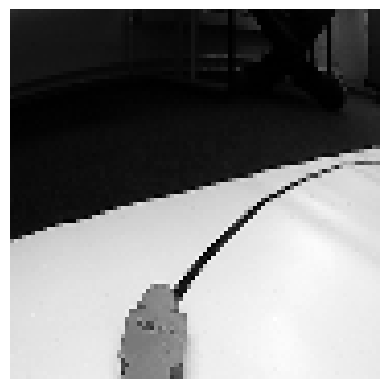

In [19]:
def prepare_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (90, 90))
    img = img / 255.0
    print(img.shape)
    img = np.expand_dims(img, axis=-1)  # Add a single channel dimension
    img = np.tile(img, (1, 1, 1))  # Duplicate the channel to simulate RGB
    print(img.shape)
    img = np.expand_dims(img, axis=0)  # Add the batch dimension correctly after tiling
    print(img.shape)
    return img, img.squeeze()

# Choose an image from your dataset or test generator
img_path = '/kaggle/input/mliscar2/test_data/test_data/10.png'
image, image_display = prepare_image(img_path)
print("Image shape for model input:", image.shape)

# Display the image
plt.imshow(image_display, cmap='gray')
plt.axis('off')
plt.show()

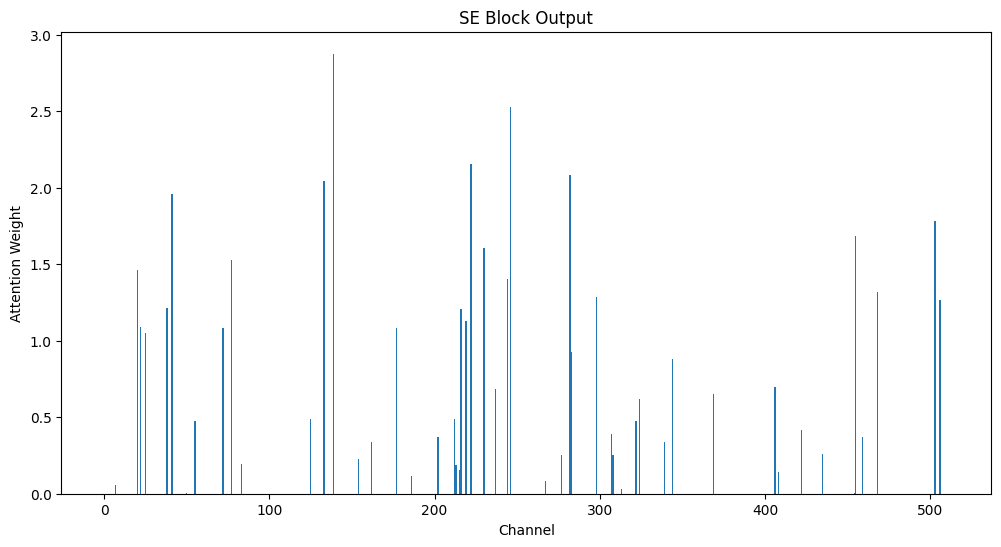

In [24]:
def visualize_se_block(model, input_tensor):
    # Get the output of the SE block
    se_block_output = model.get_layer('se_block').output
    se_block_model = Model(inputs=model.input, outputs=se_block_output)
    se_block_output_tensor = se_block_model(input_tensor)

    # Visualize the SE block output
    se_block_output_array = np.squeeze(se_block_output_tensor)
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(se_block_output_array)), se_block_output_array)
    plt.xlabel('Channel')
    plt.ylabel('Attention Weight')
    plt.title('SE Block Output')
    plt.show()
visualize_se_block(model, image)